In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Section 1: Introduction

### Section 1.1: Outline

### Section 1.2: Loading the Data

In [2]:
df = pd.read_csv('tx19_bridges_sample.csv')
df = df.set_index('Structure_id')
df.head()

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


## Section 2: Data Preparation
For the purposes of linear regression we require predictor variables. The variables agreed on for this task are Age, AverageDaily (number of vehicles), Trucks_percent (percentage of traffic that are trucks), Material (construction material of the bridge) and Design (type of bridge). The current condition is derived from the three variables Superstr_rating, Substr_rating and Deck_rating. These variables will be combined later on to create a single total to rate each bridge that we can use as our target in linear regression. We also need to decide on a boundary for our bridge age to remove older outlying bridges that may have a negative effect on our regression. 

### Section 2.1: Calculating bridge age
The data does not contain the important variable Age, however we can calculate this by subtracting the existing variable of Year (of bridge construction) from the current year (2021). 

In [3]:
df['age'] = 2021 - df['Year']
df[['Year','age']].head()

,Year,age
Structure_id,,
000021521-00101,2005,16
000021521-00181,2005,16
000021521-TMP20,2012,9
000021525-00012,1950,71
000021580-00092,2004,17


### Section 2.2: Selecting relevant variables and defining categorical variables
It is important that all variables are defined correctly within the dataframe so that operations run properly, especially later on in converting the categorical variables into continuous variables to act as predictors.  

In [4]:
df1 = df[['age', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Deck_rating', 'Superstr_rating', 'Substr_rating']].copy()
df1[['Material', 'Design', 'Deck_rating', 'Superstr_rating', 'Substr_rating']] = df1[['Material', 'Design', 'Deck_rating', 'Superstr_rating', 'Substr_rating']].astype('category')
df1.dtypes

age                   int64
AverageDaily          int64
Trucks_percent      float64
Material           category
Design             category
Deck_rating        category
Superstr_rating    category
Substr_rating      category
dtype: object

### Section 2.3: Calculating Total ranking 
There are many categorical labels within the Deck, Superstructure and Substructure rating columns. The distance between these values is difficult to calculate (what is the mathematical difference between 'Critical' and 'Serious'?). To counteract this we have grouped values that are close together and assigned them numerical values that can be operated on. We have also removed NaN values to prevent any bridges being lacking a value that could affect its score. (An issue arose with using the standard .dropna() function hence the slightly unconventional method of removing NaN values).  

In [5]:
df2 = df1.copy()
df2.Deck_rating = df2.Deck_rating.apply(lambda x: 0 if x == 'Failed' else 1 if x in ['Critical', 'Serious', 'Failing']
                                     else 2 if x in ['Poor', 'Satisfactory'] else 3 if x in ['Fair', 'Good'] else 4 if x in ['Excellent', 'Very Good'] else x) 
df2 = df2.loc[~df2.Deck_rating.isna()].copy()

df2.Superstr_rating = df2.Superstr_rating.apply(lambda x: 0 if x == 'Failed' else 1 if x in ['Critical', 'Serious', 'Failing']
                                     else 2 if x in ['Poor', 'Satisfactory'] else 3 if x in ['Fair', 'Good'] else 4 if x in ['Excellent', 'Very Good'] else x)
df2 = df2.loc[~df2.Superstr_rating.isna()].copy()

df2.Substr_rating = df2.Substr_rating.apply(lambda x: 0 if x == 'Failed' else 1 if x in ['Critical', 'Serious', 'Failing']
                                     else 2 if x in ['Poor', 'Satisfactory'] else 3 if x in ['Fair', 'Good'] else 4 if x in ['Excellent', 'Very Good'] else x)
df2 = df2.loc[~df2.Substr_rating.isna()].copy()

df2['Score'] = df2.Deck_rating + df2.Superstr_rating + df2.Substr_rating
df2.head()

,age,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Score
Structure_id,,,,,,,,,
000021521-00101,16,1,0.0,Concrete,Slab,3.0,4.0,4,11.0
000021521-00181,16,1,0.0,Concrete,Slab,3.0,3.0,4,10.0
000021521-TMP20,9,100,0.0,Concrete,Beam,4.0,4.0,4,12.0
000021525-00012,71,80,0.0,Timber,Beam,3.0,3.0,2,8.0
000021580-00092,17,150,4.0,Concrete,Beam,3.0,4.0,4,11.0


### Section 2.4: Removing old bridges
The method used to determine which bridges to remove from the dataset based on age is related to the bridge construction materials and design styles. To get an overall view of the data and as much useful information for the linear regression to be as accurate as possible it should use as many different types of material and design as possible. On the boxplots a clear boundary emerges as for both design and material, none have their third quartile over the 100 year line. Whilst there are outliers from above the 60 year mark for Timber material bridges and 80 year mark for Other design bridges, if we removed either of these as our boundaries we would lose all data for both Masonry constructed bridges and Truss designed bridges. Using a 100 year boundary therefore keeps all this main data from these older bridges but should remove the most extreme outliers.  

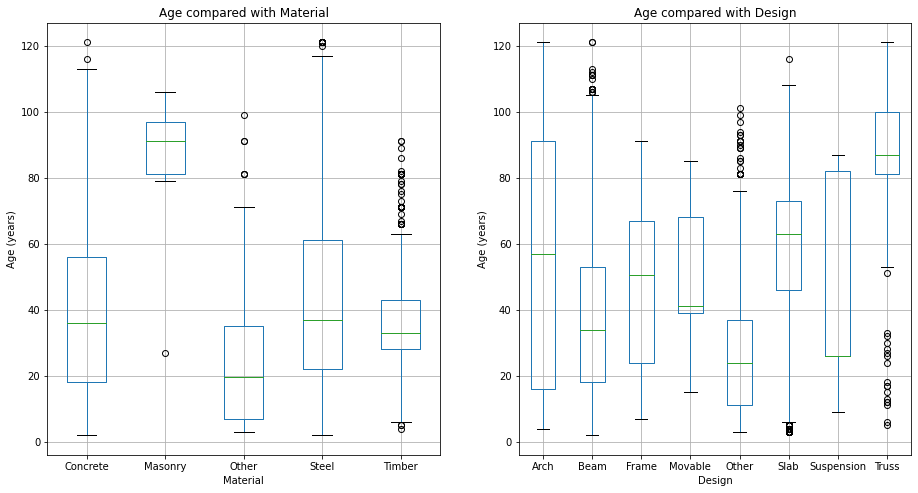

In [6]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(15,8))
a1 = df2.boxplot(column='age', by='Material', ax=a1)
a1.set_ylabel('Age (years)')
a1.set_title('Age compared with Material')
a2 = df2.boxplot(column='age', by='Design', ax=a2)
a2.set_ylabel('Age (years)')
a2.set_title('Age compared with Design')
plt.suptitle('')
plt.show()
df2 = df2[df2.age <= 100]

## Section 3: Exploratory Data Analysis

### Section 3.1: Comparing continuous variables
Our initial continuous predictors are Age, AverageDaily and Trucks_percent. It is best if none of these variables have a major correlation or association with another as this may adversely affect our regression. As we have created a Score target variable, we can remove the Deck, Superstructure and Substructure ratings. Having the Score variable at this stage is useful as we can also compare our initial predictors and see whether there is any initial correlation that we could confirm later during the linear regression. 

### Section 3.1.2: Removing Ratings

In [7]:
df3 = df2[['age', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Score']].copy()
df3.head()

,age,AverageDaily,Trucks_percent,Material,Design,Score
Structure_id,,,,,,
000021521-00101,16,1,0.0,Concrete,Slab,11.0
000021521-00181,16,1,0.0,Concrete,Slab,10.0
000021521-TMP20,9,100,0.0,Concrete,Beam,12.0
000021525-00012,71,80,0.0,Timber,Beam,8.0
000021580-00092,17,150,4.0,Concrete,Beam,11.0


## Section 3.1.3: Plotting a Scatter Matrix
From this scatter matrix it is difficult to see any correlation between our continuous variables. There also doesn't appear to be much association between our predictors and our target variable of score. From the distributions plotted through the diagonal we can see that both Trucks_percent and AverageDaily are quite significantly positively skewed with age also displaying a slight skew but not to the extreme as the other two. \
For both AverageDaily and Trucks_percent this high skew could be expected as there are a large number of bridges in this dataset (34152 after initial preparation). It would make sense that a vast majority of them would see low amounts of daily traffic or trucks. What is surprising is the lack of clear correlation between these two predictors and score, it could be feasible to expect bridges with higher usage or more trucks to have a lower score and require more repair and attention, however this is not displayed in this scatter matrix. Age is the only predictor that may have a slight negative correlation with Score as we can see that as Age increases, the number of higher scoring bridges decreases, this would make sense due to general wear and tear that an older bridge may have accrued over its lifetime, along with potentially worse building materials or construction methods that were used to create it at the time. 

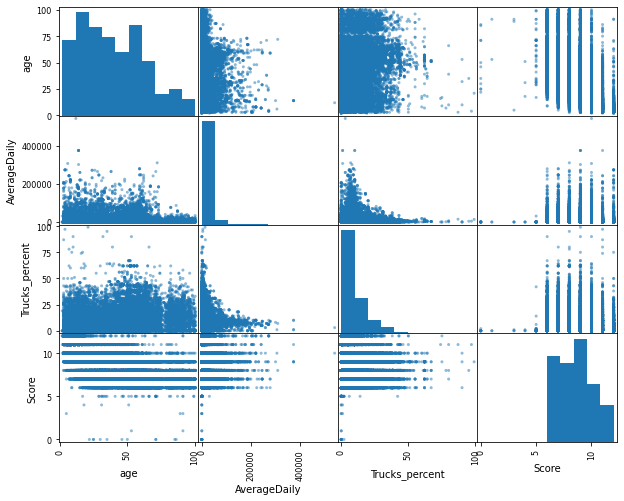

In [8]:
scatter = pd.plotting.scatter_matrix(df3,figsize=(10,8))

## Section 3.1.4: Plotting a Heatmap
This heatmap confirms our suspicions from the scatter matrix above, we can see that the majority of our predictors are not associated with one another. The major correlation appears for Age and Score being quite significantly negatively correlated, this may be something that appears in our linear regression model and may demonstrate Age to be an important variable in predicting bridge score. The lack of assocation between AverageDaily and Trucks_percent makes sense as you would expect a bridge that has a low number of vehicles overall to therefore also have a low number of trucks. Age shares a slight positive correlation with Trucks_percent, however it does not appear to be significant enough as to affect our results. It may be a fluke or perhaps older bridges are more common around areas where trucks are more prevalent.

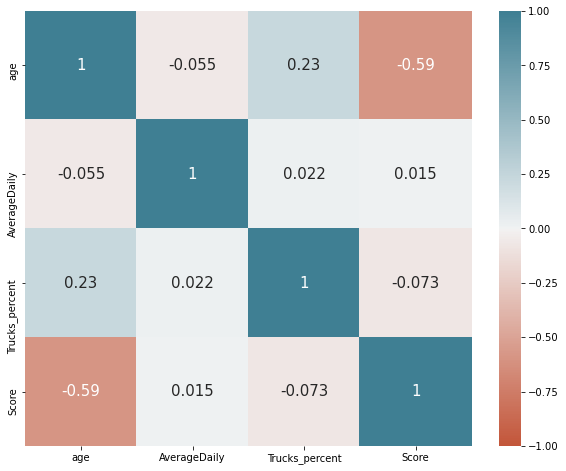

In [9]:
fig,ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(df3.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
plt.show()

## Section 3.2: Comparing Categorical Variables

### Section 3.2.1: Design given Material
We can calculate the conditional probability relations of our categorical variables using a crosstab and plotting a bar chart. A number of observations jump out from this data, the first being that if the design is either Frame or Slab then the probability of the material being used in its construction being concrete is 100%. What is perhaps more noticeable in the bar chart is the separation of designs being used for concrete and steel bridges. Designs such as Frame, Beam, Slab and Other have a greater probability of being made from Concrete whilst designs such as Truss, Suspension and Movable and have a higher probability for Steel bridges. Arch has similar probabilities of being used for both Concrete and Steel whilst Masonry, Other and Timber don't have much data. The lack of data for these Materials is most likely due to there being low numbers of these bridges within the dataset. \
The grouping of the designs in Concrete and Steel is most likely due to some designs working better for those specific materials. How this relates to the total and predicting the bridge condition can be explored further on. 

In [56]:
mat_given_des = pd.crosstab(df3.Material, df3.Design,normalize='columns')
mat_given_des.round(4)*100

Design,Arch,Beam,Frame,Movable,Other,Slab,Suspension,Truss
Material,,,,,,,,
Concrete,49.64,76.69,100.0,0.00,74.41,100.0,0.0,0.0
Masonry,7.91,0.00,0.0,0.00,0.00,0.0,0.0,0.0
Other,4.32,0.00,0.0,7.69,3.31,0.0,0.0,0.0
Steel,38.13,21.67,0.0,92.31,22.28,0.0,80.0,100.0
Timber,0.00,1.64,0.0,0.00,0.00,0.0,20.0,0.0


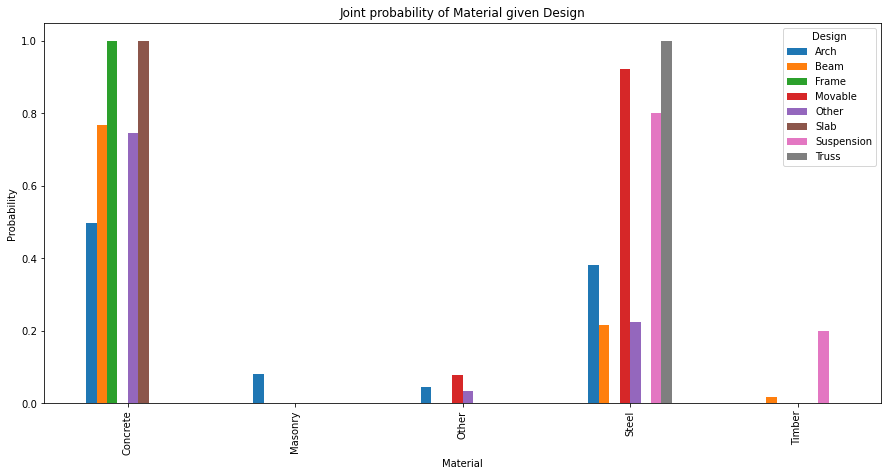

In [57]:
mat_given_des.plot(kind='bar',figsize=(15,7))
plt.title('Joint probability of Material given Design')
plt.ylabel('Probability')
plt.show()

### Section 3.2.2: Material given Design
This is the conditional probability from the other direction, providing the probability of the Design given you know what Material the bridge uses. The most immediate figure that arises from this chart and graph is that if the bridge is made from Masonry, the probability that the design it uses is Arch is 100%. Again, this could be due to building methods that were available when these Masonry bridges were constructed. Looking back at section 2.4 we can see that Masonry bridges are primarily the oldest in our dataset, this may explain why only Arch designs were used in their construction as Arch also has the greatest range of use in years and therefore was probably the most well known design at the time. \
For both Concrete and Steel, there is a very high probability that the design will be Beam. This may seem at odds with the previous graph of 3.2.1 as Beam appears to have a lower probability with Steel than with Concrete. This discrepancy could be explained by the far greater number of Concrete bridges than Steel bridges overall (27050 Concrete to 6578 Steel). What the plot below is showing is that if the bridge is made from Concrete or Steel then it has an 80% or 93% chance of being a Beam bridge, whilst the graph in 3.2.1 says that if the bridge is a Beam designed bridge, it has a higher chance of being Concrete than Steel most likely due to the far higher numbers of Concrete bridges overall compared to Steel bridges. \
The effects of this may impact our linear regression as the majority of our bridges appear to be Beam designed bridges, it may therefore make our regression more accurate for these types of bridges but less accurate for the designs which are less represented such as Movable, Slab or Suspension. 

In [58]:
des_given_mat = pd.crosstab(df3.Material, df3.Design, normalize='index')
des_given_mat.round(4)*100

Design,Arch,Beam,Frame,Movable,Other,Slab,Suspension,Truss
Material,,,,,,,,
Concrete,0.26,80.16,0.25,0.00,3.41,15.93,0.00,0.00
Masonry,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Other,12.50,0.00,0.00,2.08,85.42,0.00,0.00,0.00
Steel,0.81,93.14,0.00,0.18,4.20,0.00,0.06,1.61
Timber,0.00,99.78,0.00,0.00,0.00,0.00,0.22,0.00


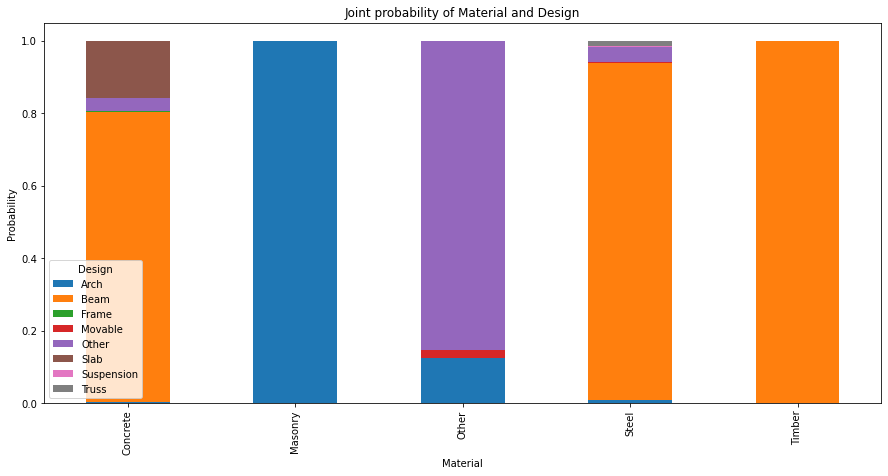

In [60]:
des_given_mat.plot(kind='bar',figsize=(15,7),stacked=True)
plt.title('Joint probability of Material and Design')
plt.ylabel('Probability')
plt.show()

## Section 3.3: Comparing Categorical and Continuous Variables

### Section 3.3.1: Comparing Age to Design and Material
An effective way to compare continuous and categorical variables is to use boxplots. This boxplot was plotted earlier at 2.4 in determining which old bridges to remove. This version is updated with the range of bridges that we will be using in the final linear regression. A number of things jump out immediately, such as the cutoff for using Masonry bridges around 80 years ago. This coincides quite clearly with the Second World War and this may have lead to their production being halted and then never resumed once other materials were seen to be either superior or easier to work with. WW2 may also coincide with the outliers in Timber bridges as steel and concrete may have been prioritised for the war effort, leaving domestic bridges to be constructed from other materials such as Timber. \
The vast majority of bridges in total appear to have been constructed from 20 to 60 years ago as these are the interquartile ranges of both Concrete and Steel which comprise most of our dataset (98%). This may mean that our linear regression will be more effective for bridges within these age ranges but not as effective as predicting the score for ages older or younger.

In [71]:
len(df3[df3.Design == 'Beam'])/len(df3)

0.8278870929960178

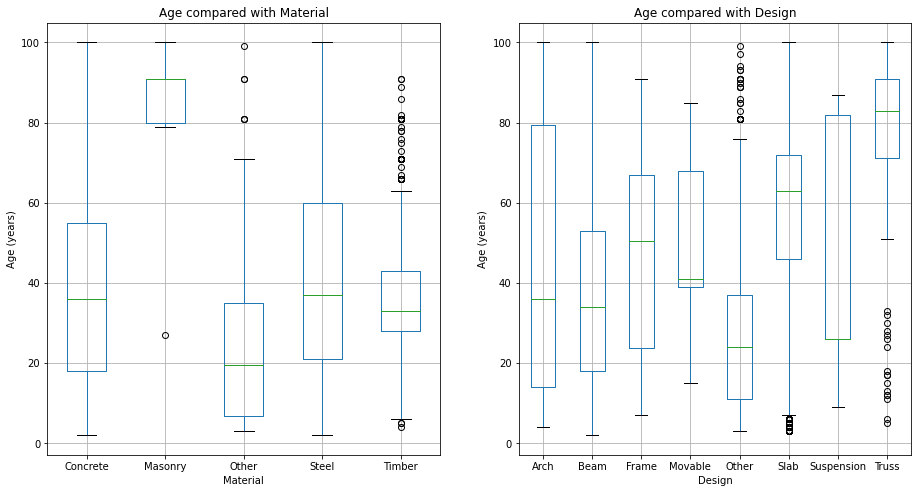

In [64]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(15,8))
a1 = df3.boxplot(column='age', by='Material', ax=a1)
a1.set_ylabel('Age (years)')
a1.set_title('Age compared with Material')
a2 = df3.boxplot(column='age', by='Design', ax=a2)
a2.set_ylabel('Age (years)')
a2.set_title('Age compared with Design')
plt.suptitle('')
plt.show()

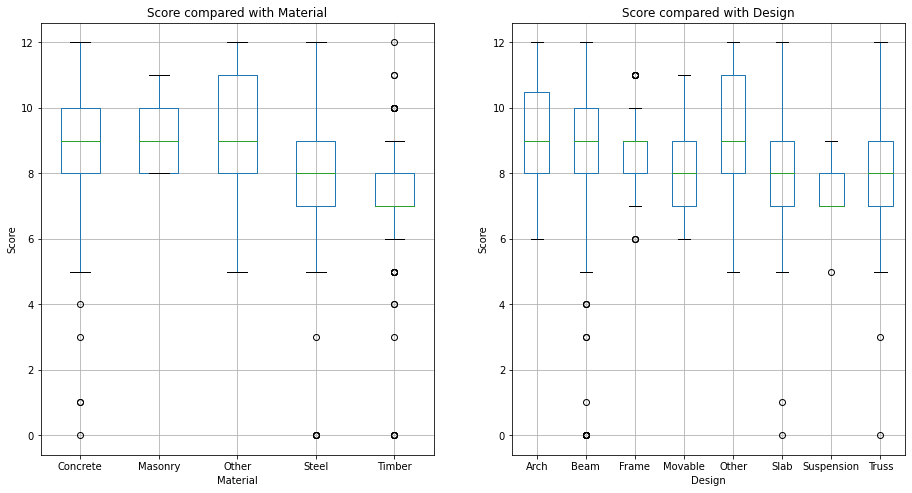

In [66]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(15,8))
a1 = df3.boxplot(column='Score', by='Material', ax=a1)
a1.set_ylabel('Score')
a1.set_title('Score compared with Material')
a2 = df3.boxplot(column='Score', by='Design', ax=a2)
a2.set_ylabel('Score')
a2.set_title('Score compared with Design')
plt.suptitle('')
plt.show()